In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from utils.utils import set_seed
set_seed()


from datetime import datetime, timedelta
from torch_geometric.nn import GATv2Conv, GATConv
from torch_geometric.utils import dense_to_sparse
from torch.distributions import Normal, Laplace, RelaxedOneHotCategorical
from torchdiffeq import odeint  # For continuous-time normalizing flows

from feature.scalers import ranged_scaler
from feature.engineering import *
from CARAT.model_utils import *
from CARAT.model import CausalGraphVAE
from CARAT.components import *
from utils.utils import set_seed, logger

# Torch settings
#torch.use_deterministic_algorithms(False)
#torch.backends.cudnn.benchmark = False
#torch.autograd.profiler.profile(enabled=False)
#torch.autograd.profiler.emit_nvtx(enabled=False)
#torch.autograd.set_detect_anomaly(mode=False)

# Environment variables
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Set device
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# Suppress warnings
warnings.filterwarnings('ignore')

# Load data
data = []
with open('data/TEP/idv1/y.dat', 'r') as file:
    for line in file:
        columns = line.strip().split("\t")
        data.append([float(col.strip()) for col in columns])


In [2]:
vars = len(data[0])
col_names = []
for i in  range(0,vars):
    col_names.append('x_'+str(i+1))
    

In [3]:
import polars as pl
from feature.scalers import ranged_scaler
df = pl.DataFrame(data,schema=col_names)
for col in df.columns:
    df = df.with_columns(ranged_scaler(df[col]))

In [4]:
df = make_stationary(df)

Column: x_1 | Final ADF: -5.4811 | p-value: 0.0000 | Diffs: 1
Column: x_2 | Final ADF: -3.6982 | p-value: 0.0003 | Diffs: 0
Column: x_3 | Final ADF: -3.6538 | p-value: 0.0003 | Diffs: 0
Column: x_4 | Final ADF: -3.3276 | p-value: 0.0010 | Diffs: 0
Column: x_5 | Final ADF: -28.9652 | p-value: 0.0000 | Diffs: 1
Column: x_6 | Final ADF: -27.3830 | p-value: 0.0000 | Diffs: 1
Column: x_7 | Final ADF: -5.1194 | p-value: 0.0000 | Diffs: 1
Column: x_8 | Final ADF: -30.8786 | p-value: 0.0000 | Diffs: 1
Column: x_9 | Final ADF: -3.0565 | p-value: 0.0024 | Diffs: 0
Column: x_10 | Final ADF: -5.8785 | p-value: 0.0000 | Diffs: 1
Column: x_11 | Final ADF: -5.5060 | p-value: 0.0000 | Diffs: 1
Column: x_12 | Final ADF: -27.0496 | p-value: 0.0000 | Diffs: 1
Column: x_13 | Final ADF: -5.5245 | p-value: 0.0000 | Diffs: 1
Column: x_14 | Final ADF: -29.4428 | p-value: 0.0000 | Diffs: 1
Column: x_15 | Final ADF: -23.7157 | p-value: 0.0000 | Diffs: 1
Column: x_16 | Final ADF: -5.1058 | p-value: 0.0000 | Diff

In [5]:
df=df.to_pandas()

In [6]:
#random dates, trivial for this exercise

start_date = '2023-03-01'  # Define the start date
date_range = pd.date_range(start=start_date, periods=df.shape[0])

In [7]:
n_lags = most_frequent(find_optimal_lags_for_dataframe(df))+1

In [8]:
df['time']=date_range

<Axes: xlabel='None', ylabel='x_44'>

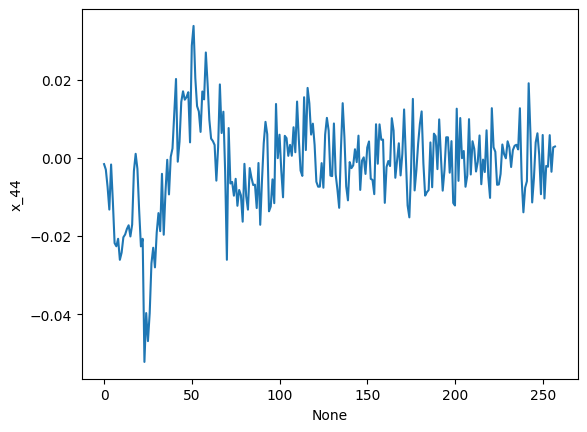

In [9]:
sns.lineplot(data=df,y='x_44',x=df.index)

In [10]:
df = df[['x_1', 'x_4','x_7','x_13','x_16','x_18','x_19','x_44','x_50']]

In [11]:
normal = df[200:]
bad = df[0:200]

In [12]:
df.columns

Index(['x_1', 'x_4', 'x_7', 'x_13', 'x_16', 'x_18', 'x_19', 'x_44', 'x_50'], dtype='object')

In [13]:
try:
    df = df.drop('time',axis=1)
except:
    None

try:
    normal = normal.drop('time',axis=1)
except:
    None
try:
    bad = bad.drop('time',axis=1)
except:
    None

In [14]:
cols = df.columns.tolist()

In [15]:
cols

['x_1', 'x_4', 'x_7', 'x_13', 'x_16', 'x_18', 'x_19', 'x_44', 'x_50']

# Pretraining

In [16]:
import torch
import random
import numpy as np

# Define the seed value
seed = 42

# Set seed for PyTorch
torch.manual_seed(seed)

# Set seed for CUDA (if using GPUs)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# Set seed for Python's random module
random.seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Ensure deterministic behavior for PyTorch operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [35]:
TIME_STEPS = 7
BATCH_SIZE = 25
hidden_dim = 64
latent_dim = 8
dataset_nominal = TimeSeriesDataset(normal, device=device, time_steps=TIME_STEPS)
dataloader_nominal = DataLoader(dataset_nominal, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model and optimizer
model = CausalGraphVAE(input_dim=normal.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=normal.shape[1],device=device,
                        time_steps=TIME_STEPS, prior_adj=None,instantaneous_weight=0.1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4, amsgrad =True)

# Train on nominal data
#print("Pretraining on nominal data...")
model.train_model(dataloader_nominal, optimizer, num_epochs=200, patience=20,
                  BATCH_SIZE=BATCH_SIZE,rho_max=4,alpha_max=2)

# Extract learned adjacency
prior_adj = model.causal_graph.adj_mat.clone().detach()
pd.DataFrame((prior_adj).cpu().detach().numpy(),index=cols,columns=cols)

Epoch 1: Loss = 301.9690
Recon Loss = 320.1398, KL Loss = 0.0000, Lagrangian Loss = 29.4586
Epoch 51: Loss = 15.1541
Recon Loss = 15.0322, KL Loss = 0.7678, Lagrangian Loss = 6.3340
Epoch 101: Loss = 5.9774
Recon Loss = 5.4800, KL Loss = 0.5173, Lagrangian Loss = 2.7307
Epoch 151: Loss = 3.7469
Recon Loss = 3.4642, KL Loss = 0.3201, Lagrangian Loss = 1.9046


,x_1,x_4,x_7,x_13,x_16,x_18,x_19,x_44,x_50
x_1,0.000000,0.463701,0.331602,0.357082,0.332337,0.446658,0.325793,0.330286,0.322070
x_4,0.280336,0.000000,0.356729,0.386473,0.404197,0.305971,0.384953,0.407404,0.302840
x_7,0.322337,0.387143,0.000000,0.415536,0.332255,0.468466,0.347451,0.317093,0.378922
x_13,0.284771,0.357019,0.285732,0.000000,0.314734,0.350673,0.400621,0.369002,0.323369
x_16,0.283832,0.420236,0.353251,0.299617,0.000000,0.318161,0.317730,0.315012,0.312234
x_18,0.371586,0.340347,0.283001,0.410161,0.308738,0.000000,0.311795,0.422890,0.392977
x_19,0.311184,0.412615,0.289547,0.305193,0.327827,0.336896,0.000000,0.288606,0.415722
x_44,0.369653,0.419239,0.358901,0.412631,0.405392,0.334310,0.399950,0.000000,0.318081
x_50,0.298846,0.308027,0.315350,0.326999,0.404068,0.388763,0.302975,0.319219,0.000000


In [37]:
TIME_STEPS = 7
BATCH_SIZE = 25
hidden_dim = 64
latent_dim = 8
edge_correct = 0
instantaneous_correct = 0
lagged_correct = 0
counterfactual_correct = 0 
rr_correct = 0
total_correct = 0
total_checked = 0
for i in range(30):
    total_checked+=1

    dataset_bad = TimeSeriesDataset(bad, device=device, time_steps=TIME_STEPS)
    dataloader_bad = DataLoader(dataset_bad, batch_size=BATCH_SIZE, shuffle=True)
    
    # Initialize model and optimizer
    fine_tuned = CausalGraphVAE(input_dim=bad.shape[1], hidden_dim=hidden_dim,
                            latent_dim=latent_dim, num_nodes=bad.shape[1],device=device,
                            time_steps=TIME_STEPS, prior_adj=prior_adj,instantaneous_weight=0.1).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Train on nominal data
    # print("Pretraining on nominal data...")
    fine_tuned.train_model(dataloader_bad, optimizer, num_epochs=200, patience=20,
                           BATCH_SIZE=BATCH_SIZE,rho_max=4,alpha_max=2)
    
    X_data = torch.empty(0,device=device)
    T_data = torch.empty(0,device=device)
    for batch_idx, (X_batch, time_batch) in enumerate(dataloader_bad):
        X_data = torch.cat((X_data[:batch_idx], X_batch, X_data[batch_idx:]))
        T_data = torch.cat((T_data[:batch_idx], time_batch, T_data[batch_idx:]))
    
    causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_4',cols,non_causal_indices=[])
    
    edge_cause_1 = causes.sort_values(by='causes',ascending=False)[0:3].index[0]
    edge_cause_2 = causes.sort_values(by='causes',ascending=False)[0:3].index[1]
    edge_cause_3 = causes.sort_values(by='causes',ascending=False)[0:3].index[2]
    
    instant_cause_1 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[0]
    instant_cause_2 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[1]
    instant_cause_3 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[2]
    
    lag_cause_1 = causes.sort_values(by='lagged',ascending=False)[0:3].index[0]
    lag_cause_2 = causes.sort_values(by='lagged',ascending=False)[0:3].index[1]
    lag_cause_3 = causes.sort_values(by='lagged',ascending=False)[0:3].index[2]
    
    counterfactual_cause_1 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[0]
    counterfactual_cause_2 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[1]
    counterfactual_cause_3 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[2]
    
    rr_cause_1 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[0]
    rr_cause_2 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[1]
    rr_cause_3 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[2]
    
    total_score_cause_1=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[0]
    total_score_cause_2=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[1]
    total_score_cause_3=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[2]
    
    if (edge_cause_1 in ['x_1','x_44']) | (edge_cause_2 in ['x_1','x_44']) | (edge_cause_3 in ['x_1','x_44']):
        edge_correct+=1
    
    if (  total_score_cause_1 in ['x_1','x_44']) | (total_score_cause_2 in ['x_1','x_44']) | ( total_score_cause_3 in ['x_1','x_44']):
        total_correct+=1
    
    if (counterfactual_cause_1 in ['x_1','x_44']) | (counterfactual_cause_2 in ['x_1','x_44']) | (counterfactual_cause_3 in ['x_1','x_44']):
        counterfactual_correct+=1
    
    if (instant_cause_1 in ['x_1','x_44']) | (instant_cause_2 in ['x_1','x_44']) |( instant_cause_3 in ['x_1','x_44'] ):
        instantaneous_correct+=1
    
    if (lag_cause_1 in ['x_1','x_44']) | (lag_cause_2 in ['x_1','x_44'])  | (lag_cause_3 in ['x_1','x_44']):
        lagged_correct+=1
    
    if (rr_cause_1 in ['x_1','x_44']) | (rr_cause_2 in ['x_1','x_44']) | (rr_cause_3 in ['x_1','x_44']):
        rr_correct+=1
        
    total_accuracy = total_correct/total_checked* 100
    edge_accuracy = edge_correct/total_checked* 100
    cf_accuracy = counterfactual_correct/total_checked* 100
    instant_accuracy = instantaneous_correct/total_checked* 100
    lag_accuracy = lagged_correct/total_checked* 100
    rr_accuracy = rr_correct/total_checked* 100
    
    
    logger.info(f"Edge Accuracy = {edge_accuracy:.2f}, Instantaneous Accuracy = {instant_accuracy:.2f}, Lagged Accuracy = {lag_accuracy:.2f}, Counterfactual Accuracy = {cf_accuracy:.2f},  Blended Accuracy = {total_accuracy:.2f},  RR Accuracy = {rr_accuracy:.2f}  ") 
    


Epoch 1: Loss = 484.7809
Recon Loss = 333.8819, KL Loss = 0.0000, Lagrangian Loss = 56.8405
Early stopping triggered. Last Epoch: 36
Recon Loss = 329.0327, KL Loss = 0.1503, Lagrangian Loss = 59.2672


2025-03-22 16:37:09,769 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 100.00,  Blended Accuracy = 100.00,  RR Accuracy = 100.00  


Epoch 1: Loss = 507.1897
Recon Loss = 361.4441, KL Loss = 0.0000, Lagrangian Loss = 33.1681
Early stopping triggered. Last Epoch: 41
Recon Loss = 342.6387, KL Loss = 0.1417, Lagrangian Loss = 35.1250


2025-03-22 16:38:35,382 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 50.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 50.00,  Blended Accuracy = 50.00,  RR Accuracy = 50.00  


Epoch 1: Loss = 511.4388
Recon Loss = 338.9256, KL Loss = 0.0000, Lagrangian Loss = 52.7374
Early stopping triggered. Last Epoch: 32
Recon Loss = 349.5581, KL Loss = 0.0735, Lagrangian Loss = 54.5671


2025-03-22 16:39:42,619 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 66.67, Lagged Accuracy = 100.00, Counterfactual Accuracy = 66.67,  Blended Accuracy = 66.67,  RR Accuracy = 66.67  


Epoch 1: Loss = 604.0389
Recon Loss = 406.5718, KL Loss = 0.0000, Lagrangian Loss = 20.9198
Early stopping triggered. Last Epoch: 42
Recon Loss = 424.7911, KL Loss = 0.2115, Lagrangian Loss = 21.6133


2025-03-22 16:41:12,350 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 75.00, Lagged Accuracy = 75.00, Counterfactual Accuracy = 75.00,  Blended Accuracy = 75.00,  RR Accuracy = 75.00  


Epoch 1: Loss = 456.8222
Recon Loss = 348.1344, KL Loss = 0.0000, Lagrangian Loss = 13.1267
Early stopping triggered. Last Epoch: 33
Recon Loss = 310.2558, KL Loss = 0.2425, Lagrangian Loss = 13.6598


2025-03-22 16:42:20,234 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 80.00, Lagged Accuracy = 80.00, Counterfactual Accuracy = 80.00,  Blended Accuracy = 80.00,  RR Accuracy = 80.00  


Epoch 1: Loss = 777.1239
Recon Loss = 542.1554, KL Loss = 0.0000, Lagrangian Loss = 32.8658
Early stopping triggered. Last Epoch: 21
Recon Loss = 607.0638, KL Loss = 0.1088, Lagrangian Loss = 33.3507


2025-03-22 16:43:07,593 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 83.33, Lagged Accuracy = 83.33, Counterfactual Accuracy = 83.33,  Blended Accuracy = 83.33,  RR Accuracy = 66.67  


Epoch 1: Loss = 562.4576
Recon Loss = 369.7958, KL Loss = 0.0000, Lagrangian Loss = 56.0608
Early stopping triggered. Last Epoch: 28
Recon Loss = 381.9231, KL Loss = 0.1249, Lagrangian Loss = 56.5409


2025-03-22 16:44:08,500 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 85.71, Lagged Accuracy = 85.71, Counterfactual Accuracy = 85.71,  Blended Accuracy = 85.71,  RR Accuracy = 71.43  


Epoch 1: Loss = 553.0990
Recon Loss = 392.5659, KL Loss = 0.0000, Lagrangian Loss = 26.5320
Early stopping triggered. Last Epoch: 26
Recon Loss = 381.0881, KL Loss = 0.0964, Lagrangian Loss = 27.1588


2025-03-22 16:45:03,179 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 87.50, Lagged Accuracy = 87.50, Counterfactual Accuracy = 75.00,  Blended Accuracy = 75.00,  RR Accuracy = 62.50  


Epoch 1: Loss = 518.4788
Recon Loss = 337.6612, KL Loss = 0.0000, Lagrangian Loss = 25.2945
Early stopping triggered. Last Epoch: 37
Recon Loss = 389.5706, KL Loss = 0.1511, Lagrangian Loss = 25.6990


2025-03-22 16:46:21,107 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 88.89, Lagged Accuracy = 88.89, Counterfactual Accuracy = 66.67,  Blended Accuracy = 66.67,  RR Accuracy = 55.56  


Epoch 1: Loss = 1049.1410
Recon Loss = 765.9597, KL Loss = 0.0000, Lagrangian Loss = 20.6219
Early stopping triggered. Last Epoch: 22
Recon Loss = 741.2787, KL Loss = 0.0930, Lagrangian Loss = 21.3788


2025-03-22 16:47:08,422 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 90.00, Lagged Accuracy = 90.00, Counterfactual Accuracy = 70.00,  Blended Accuracy = 70.00,  RR Accuracy = 50.00  


Epoch 1: Loss = 573.6832
Recon Loss = 407.8586, KL Loss = 0.0000, Lagrangian Loss = 25.2436
Epoch 51: Loss = 583.0240
Recon Loss = 405.3879, KL Loss = 0.1661, Lagrangian Loss = 27.5275
Early stopping triggered. Last Epoch: 82
Recon Loss = 399.3560, KL Loss = 0.1965, Lagrangian Loss = 30.7770


2025-03-22 16:49:49,921 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 90.91, Lagged Accuracy = 90.91, Counterfactual Accuracy = 63.64,  Blended Accuracy = 63.64,  RR Accuracy = 45.45  


Epoch 1: Loss = 587.6361
Recon Loss = 422.6593, KL Loss = 0.0000, Lagrangian Loss = 31.8225
Early stopping triggered. Last Epoch: 20
Recon Loss = 424.8174, KL Loss = 0.0973, Lagrangian Loss = 32.2058


2025-03-22 16:50:31,797 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 91.67, Lagged Accuracy = 91.67, Counterfactual Accuracy = 66.67,  Blended Accuracy = 58.33,  RR Accuracy = 41.67  


Epoch 1: Loss = 679.5358
Recon Loss = 397.3602, KL Loss = 0.0000, Lagrangian Loss = 103.3333
Early stopping triggered. Last Epoch: 22
Recon Loss = 456.2094, KL Loss = 0.0645, Lagrangian Loss = 104.9088


2025-03-22 16:51:18,053 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 92.31, Lagged Accuracy = 92.31, Counterfactual Accuracy = 61.54,  Blended Accuracy = 53.85,  RR Accuracy = 38.46  


Epoch 1: Loss = 589.8843
Recon Loss = 406.3965, KL Loss = 0.0000, Lagrangian Loss = 33.2697
Early stopping triggered. Last Epoch: 20
Recon Loss = 417.1425, KL Loss = 0.0843, Lagrangian Loss = 33.6036


2025-03-22 16:52:01,003 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 92.86, Lagged Accuracy = 92.86, Counterfactual Accuracy = 57.14,  Blended Accuracy = 50.00,  RR Accuracy = 35.71  


Epoch 1: Loss = 529.0569
Recon Loss = 370.4222, KL Loss = 0.0000, Lagrangian Loss = 23.6217
Early stopping triggered. Last Epoch: 27
Recon Loss = 382.0362, KL Loss = 0.0853, Lagrangian Loss = 24.5645


2025-03-22 16:52:57,901 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 93.33, Lagged Accuracy = 93.33, Counterfactual Accuracy = 60.00,  Blended Accuracy = 53.33,  RR Accuracy = 33.33  


Epoch 1: Loss = 553.6435
Recon Loss = 370.1905, KL Loss = 0.0000, Lagrangian Loss = 79.0300
Early stopping triggered. Last Epoch: 20
Recon Loss = 383.1198, KL Loss = 0.0680, Lagrangian Loss = 81.4537


2025-03-22 16:53:41,777 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 93.75, Lagged Accuracy = 93.75, Counterfactual Accuracy = 56.25,  Blended Accuracy = 50.00,  RR Accuracy = 31.25  


Epoch 1: Loss = 681.7816
Recon Loss = 497.0470, KL Loss = 0.0000, Lagrangian Loss = 36.3681
Early stopping triggered. Last Epoch: 32
Recon Loss = 492.8382, KL Loss = 0.1192, Lagrangian Loss = 37.3882


2025-03-22 16:54:48,327 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 88.24, Lagged Accuracy = 94.12, Counterfactual Accuracy = 52.94,  Blended Accuracy = 47.06,  RR Accuracy = 29.41  


Epoch 1: Loss = 791.5867
Recon Loss = 543.3360, KL Loss = 0.0000, Lagrangian Loss = 39.2516
Early stopping triggered. Last Epoch: 26
Recon Loss = 598.1216, KL Loss = 0.1846, Lagrangian Loss = 39.7392


2025-03-22 16:55:45,020 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 88.89, Lagged Accuracy = 94.44, Counterfactual Accuracy = 55.56,  Blended Accuracy = 50.00,  RR Accuracy = 33.33  


Epoch 1: Loss = 499.4580
Recon Loss = 372.4015, KL Loss = 0.0000, Lagrangian Loss = 42.0035
Early stopping triggered. Last Epoch: 45
Recon Loss = 314.5855, KL Loss = 0.2085, Lagrangian Loss = 43.2723


2025-03-22 16:57:20,181 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 89.47, Lagged Accuracy = 94.74, Counterfactual Accuracy = 52.63,  Blended Accuracy = 47.37,  RR Accuracy = 31.58  


Epoch 1: Loss = 498.8826
Recon Loss = 351.6253, KL Loss = 0.0000, Lagrangian Loss = 31.0221
Early stopping triggered. Last Epoch: 39
Recon Loss = 342.8387, KL Loss = 0.1672, Lagrangian Loss = 31.9012


2025-03-22 16:58:41,141 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 85.00, Lagged Accuracy = 95.00, Counterfactual Accuracy = 50.00,  Blended Accuracy = 45.00,  RR Accuracy = 30.00  


Epoch 1: Loss = 459.5073
Recon Loss = 350.5710, KL Loss = 0.0000, Lagrangian Loss = 21.2897
Epoch 51: Loss = 470.5901
Recon Loss = 355.3801, KL Loss = 0.2318, Lagrangian Loss = 23.0525
Early stopping triggered. Last Epoch: 60
Recon Loss = 321.0362, KL Loss = 0.3052, Lagrangian Loss = 23.8336


2025-03-22 17:00:43,241 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 85.71, Lagged Accuracy = 95.24, Counterfactual Accuracy = 52.38,  Blended Accuracy = 47.62,  RR Accuracy = 33.33  


Epoch 1: Loss = 478.9270
Recon Loss = 408.3813, KL Loss = 0.0000, Lagrangian Loss = 24.0013
Early stopping triggered. Last Epoch: 33
Recon Loss = 344.4483, KL Loss = 0.1290, Lagrangian Loss = 24.6741


2025-03-22 17:01:51,528 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 86.36, Lagged Accuracy = 95.45, Counterfactual Accuracy = 54.55,  Blended Accuracy = 50.00,  RR Accuracy = 31.82  


Epoch 1: Loss = 449.7954
Recon Loss = 299.8553, KL Loss = 0.0000, Lagrangian Loss = 24.0061
Early stopping triggered. Last Epoch: 39
Recon Loss = 313.6947, KL Loss = 0.1607, Lagrangian Loss = 25.3012


2025-03-22 17:03:09,600 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 86.96, Lagged Accuracy = 95.65, Counterfactual Accuracy = 52.17,  Blended Accuracy = 47.83,  RR Accuracy = 30.43  


Epoch 1: Loss = 646.8258
Recon Loss = 447.1296, KL Loss = 0.0000, Lagrangian Loss = 37.2392
Early stopping triggered. Last Epoch: 34
Recon Loss = 427.7805, KL Loss = 0.2186, Lagrangian Loss = 38.8989


2025-03-22 17:04:22,682 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 83.33, Lagged Accuracy = 95.83, Counterfactual Accuracy = 54.17,  Blended Accuracy = 50.00,  RR Accuracy = 29.17  


Epoch 1: Loss = 571.6282
Recon Loss = 402.6835, KL Loss = 0.0000, Lagrangian Loss = 16.2484
Early stopping triggered. Last Epoch: 37
Recon Loss = 388.5788, KL Loss = 0.2557, Lagrangian Loss = 17.0664


2025-03-22 17:05:41,301 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 84.00, Lagged Accuracy = 96.00, Counterfactual Accuracy = 56.00,  Blended Accuracy = 52.00,  RR Accuracy = 28.00  


Epoch 1: Loss = 649.7001
Recon Loss = 428.9756, KL Loss = 0.0000, Lagrangian Loss = 60.1817
Early stopping triggered. Last Epoch: 23
Recon Loss = 469.0947, KL Loss = 0.0702, Lagrangian Loss = 61.1114


2025-03-22 17:06:31,351 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 84.62, Lagged Accuracy = 96.15, Counterfactual Accuracy = 57.69,  Blended Accuracy = 53.85,  RR Accuracy = 30.77  


Epoch 1: Loss = 549.6066
Recon Loss = 456.1172, KL Loss = 0.0000, Lagrangian Loss = 12.9810
Early stopping triggered. Last Epoch: 33
Recon Loss = 361.5042, KL Loss = 0.0717, Lagrangian Loss = 13.4850


2025-03-22 17:07:40,583 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 85.19, Lagged Accuracy = 96.30, Counterfactual Accuracy = 55.56,  Blended Accuracy = 51.85,  RR Accuracy = 29.63  


Epoch 1: Loss = 759.9738
Recon Loss = 531.2411, KL Loss = 0.0000, Lagrangian Loss = 45.2156
Early stopping triggered. Last Epoch: 20
Recon Loss = 550.5731, KL Loss = 0.0879, Lagrangian Loss = 45.6416


2025-03-22 17:08:25,255 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 85.71, Lagged Accuracy = 96.43, Counterfactual Accuracy = 53.57,  Blended Accuracy = 50.00,  RR Accuracy = 28.57  


Epoch 1: Loss = 575.9056
Recon Loss = 374.2674, KL Loss = 0.0000, Lagrangian Loss = 64.7868
Early stopping triggered. Last Epoch: 29
Recon Loss = 379.9786, KL Loss = 0.1168, Lagrangian Loss = 66.3319


2025-03-22 17:09:26,609 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 86.21, Lagged Accuracy = 96.55, Counterfactual Accuracy = 55.17,  Blended Accuracy = 51.72,  RR Accuracy = 31.03  


Epoch 1: Loss = 659.8300
Recon Loss = 472.3612, KL Loss = 0.0000, Lagrangian Loss = 38.3919
Early stopping triggered. Last Epoch: 35
Recon Loss = 438.0121, KL Loss = 0.1183, Lagrangian Loss = 39.8292


2025-03-22 17:10:35,672 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 86.67, Lagged Accuracy = 96.67, Counterfactual Accuracy = 56.67,  Blended Accuracy = 53.33,  RR Accuracy = 33.33  
